In [58]:
documents = []

file = open('Tratando Arquivos/docs.txt', 'r')
for line in file:
    documents.append(line)
file.close()

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000 # max number of uniq words

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [60]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 40
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [61]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)
    print()

In [62]:
no_top_words = 5
display_topics(lda, tf_feature_names, no_top_words)

Topic #0: good long poor pretty play
Topic #1: today early sun gone run
Topic #2: home old let makes wishing
Topic #3: way far didnt listening updates
Topic #4: getting mean sore friday needs
Topic #5: raining tried london short trip
Topic #6: night headache awake party lovely
Topic #7: just make woke looks saturday
Topic #8: bed video laptop suck online
Topic #9: morning people bored year thought
Topic #10: wish right working watch start
Topic #11: hope come hours yesterday stuck
Topic #12: tomorrow damn missing weather life
Topic #13: http com twitpic tinyurl plurk
Topic #14: twitter week phone happy stupid
Topic #15: gonna wait ok head 10
Topic #16: hot big food ass ate
Topic #17: sick late waiting baby broken
Topic #18: going need school feeling better
Topic #19: really sorry hour ur money
Topic #20: im love car later movie
Topic #21: like got feel shit wants
Topic #22: wanna yeah sucks omg internet
Topic #23: want know wrong lot read
Topic #24: sad hate missed finally guys
Topic #

In [63]:
import pandas as pd
import numpy as np
   
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(no_topics)]

# index names
docnames = [str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
   color = 'green' if val > .1 else 'black'
   return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,dominant_topic
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0,0,0,0,0,0,0,0.13,0,0,0.13,0,0,0.13,0,0,0,0,0,0,0,0.13,0,0,0,0,13
1,0,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15,0,0,0,0,0,0,0.43,0,0,0,0,0,0,0,0,0,0,0,0,0.15,0,25
2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.6,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,18
3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,12
4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.51,0.01,0.01,0.01,36
5,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0
6,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.67,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,18
7,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6,0.1,0,0,0,0.1,0,33
8,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.51,0.01,0.01,37
9,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0


In [65]:
df_topic_distribution = df_document_topic['dominant_topic']
#df_topic_distribution.columns = ['Topic Num', 'Num Documents']
i = 0
for doc in df_topic_distribution:
    if doc == 12:
        print(documents[i])
    i = i + 1


whole body feels itchy like fire 

blagh class 8 tomorrow 

Ugh 92 degrees tomorrow 

The Life cool But Me 

Damm back school tomorrow 

Damn I chalk MY CHALKBOARD IS USELESS 

Body Of Missing Northern Calif Girl Found Police found remains missing Northern California girl http tr im imji 

thecoolestout Ehhh Weather gonna take turn ugly tomorrow 

I missing babe long alive I happy Yawwwnn I tired love imma try sleep hopefully headstart 

I saw found Tracy girl piece luggage How fucking terrible 

MizzChievouz Hey girl The site back Girlyvue back even videos 

I miss watching Rocko Modern Life 

Steve_Buscemi weather Canada freezing 

jillianfish tweet something damn hang please 

woke vivid sketchy cool dreams life time stare wall lights 

pears amp Brie bottle Cabernet quot Win Date With Tad Hamilton quot oh gawwd life flashed forward I 40 75 cats 

missing playing trumpet 

LizChavez I set feet ground The missing eyelid people might get 

nicolerichie Gossip Girl repeat 

listening M

flu amp missing Matt terribly 

heycassadee I thinking song damn 

tired wishes could see 30stm life 

johnnystorm oh dear How could u I sure devistated Keep date pix Am sat tesco Cold hungry alone 

Lying couch near River Clyde Tick tock goes clock Regretting gin 

honeyPRmelb What You Portsea tonight amp arrange drink Bring warm jackets girl freezing 

agelessdaughter DUDE I going go lexington last weekend I fucking girls research leadership academy attend 

Wishes going Catwalk Tragedy tomorrow 

I singing Luka chuppi I missing sumone 

patchyemoly bad day girl 

Im freaking late http tweet sg 

fucking sick 

No try 

sometimes girl sucks weenus 

going try sleep lola wakes eat tired 

mcdanielnc89 Same I know feeling I crazy insomia I never really sleep 

Bonfires best Studying allll day tomorrow 

Missing Lyndy 

philloau I know I go see Optus tomorrow 

misses girl 

The SAT tomorrow I want go bed 

cambriadetken aww sorry sat horrifying experience 

Its sleep time Hopefully see

In [66]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

c:\users\pc-dell\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
18     -36.627472  -31.957279       1        1  4.179971
21    -100.371048   92.358376       2        1  3.884627
33      45.454082  124.803993       3        1  3.777154
32     -34.571438    4.308692       4        1  3.352780
0       50.392197 -114.344872       5        1  3.020491
31      -7.797240  -83.751595       6        1  3.014234
1     -115.449379   -7.473755       7        1  2.996158
38      83.766167   30.296001       8        1  2.973966
20     -41.003468   41.093704       9        1  2.903233
9      134.179626   11.603314      10        1  2.892668
12      64.314667   67.259277      11        1  2.835433
11     -14.120891   95.485985      12        1  2.795169
10      60.295254    0.246905      13        1  2.715173
24     116.872269   59.839630      14        1  2.689489
25     -50.515347 -108.896782      15        1  2.662963
19    -128.796021   39.934864      16        1  2.661403
15     119.903526  -56.372105      17        1  2.658484
23     -55.144924  124.284027      18        1  2.653932
14     -83.808403   46.457626      19        1  2.614364
35      25.406216  -36.773094      20        1  2.606041
36     -95.395966  -77.017014      21        1  2.584143
34      -1.666003  137.225159      22        1  2.567178
27      98.780930  -16.117598      23        1  2.509238
7       30.634544  -74.372993      24        1  2.499061
29      36.068783   37.697403      25        1  2.456368
13     -79.785286  -34.539753      26        1  2.409000
26     -10.399673  -32.477203      27        1  2.332349
6       89.249756  102.894600      28        1  2.285095
22      -3.541448   56.757252      29        1  2.280825
39      -2.763132   20.545168      30        1  2.018219
2      -72.853676    7.105660      31        1  2.018007
4       63.340355  -40.027431      32        1  1.928772
17      26.533175   82.033913      33        1  1.743556
3      -47.259521  -67.259689      34        1  1.651363
8       78.158623  -77.937416      35        1  1.572010
30     -51.169098   77.228470      36        1  1.560737
37      23.443951   -0.748642      37        1  1.557800
16    -154.716522  -47.610947      38        1  1.440101
28       7.539432 -141.901917      39        1  1.374361
5      -51.458286 -164.284393      40        1  1.324087, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
970   Default  3382.000000         work  3382.000000  30.0000  30.0000
208   Default  2669.000000          day  2669.000000  29.0000  29.0000
860   Default  2436.000000        today  2436.000000  28.0000  28.0000
512   Default  2290.000000         like  2290.000000  27.0000  27.0000
701   Default  1802.000000       really  1802.000000  26.0000  26.0000
373   Default  1862.000000         good  1862.000000  25.0000  25.0000
927   Default  1785.000000         want  1785.000000  24.0000  24.0000
370   Default  2023.000000        going  2023.000000  23.0000  23.0000
379   Default  1975.000000          got  1975.000000  22.0000  22.0000
460   Default  1731.000000           im  1731.000000  21.0000  21.0000
433   Default  1517.000000         home  1517.000000  20.0000  20.0000
769   Default  1539.000000        sleep  1539.000000  19.0000  19.0000
687   Default  1585.000000         quot  1585.000000  18.0000  18.0000
618   Default  1446.000000        night  1446.000000  17.0000  17.0000
856   Default  1664.000000         time  1664.000000  16.0000  16.0000
720   Default  1418.000000          sad  1418.000000  15.0000  15.0000
446   Default  1370.000000         http  1370.000000  14.0000  14.0000
845   Default  1357.000000        think  1357.000000  13.0000  13.0000
490   Default  1386.000000         know  1386.000000  12.0000  12.0000
626   Default  1355.000000           oh  1355.000000  11.0000  11.0000
8

Text(0.5,1,'Segregation of Topic Clusters')

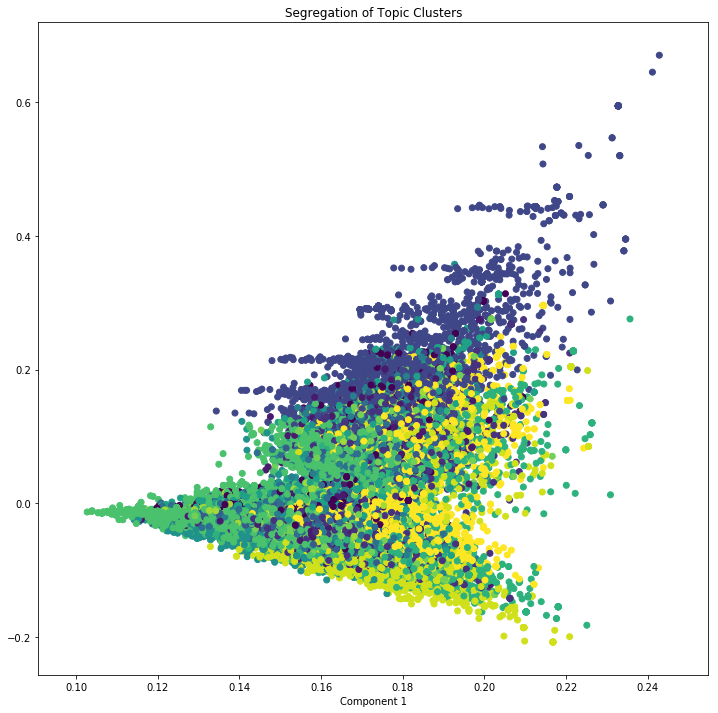

In [67]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )